## SETTUP

In [2]:
# 🧠 Brain Stroke CT Classification using 2D CNN
# --------------------------------------------------
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import glob
from PIL import Image
import torchvision.models as models
from torchvision import transforms
from tqdm import tqdm
import random

In [3]:
# --------------------------------------------------
# 🌱 Set Random Seeds for Reproducibility
# --------------------------------------------------
def set_seed(seed=42):
    """
    Set random seeds for reproducibility across all libraries
    """
    random.seed(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed) # if usiing CPU
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seeds set to {seed} for reproducibility")

# Set random seeds
set_seed(42)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Random seeds set to 42 for reproducibility


In [4]:
# --------------------------------------------------
# ✅ Dataset path and structure analysis
# --------------------------------------------------
dataset_path = "Brain_Stroke_CT_Dataset"

# Analyze dataset structure to understand what files are available
def analyze_dataset(root_dir):
    structure = {}
    for root, dirs, files in os.walk(root_dir):
        rel_dir = os.path.relpath(root, root_dir)
        if rel_dir == '.':
            continue
            
        # Count files by extension
        file_counts = {}
        for f in files:
            ext = os.path.splitext(f)[1].lower()
            if ext in file_counts:
                file_counts[ext] += 1
            else:
                file_counts[ext] = 1
                
        structure[rel_dir] = file_counts
        
    return structure

dataset_structure = analyze_dataset(dataset_path)
print("Dataset structure:")
for dir_path, file_types in dataset_structure.items():
    print(f"{dir_path}: {file_types}")

Dataset structure:
External_Test: {'.csv': 1}
External_Test\DICOM: {'.dcm': 200}
External_Test\MASKS: {'.png': 200}
External_Test\OVERLAY: {'.png': 200}
External_Test\PNG: {'.png': 200}
hemorrhagic: {}
hemorrhagic\DICOM: {'.dcm': 1093}
hemorrhagic\OVERLAY: {'.png': 1093}
hemorrhagic\PNG: {'.png': 1093}
Ischemia: {}
Ischemia\DICOM: {'.dcm': 1130}
Ischemia\OVERLAY: {'.png': 1130}
Ischemia\PNG: {'.png': 1130}
Normal: {}
Normal\DICOM: {'.dcm': 4427}
Normal\PNG: {'.png': 4427}


In [5]:
# --------------------------------------------------
# 📊 Data Loading and Preprocessing
# --------------------------------------------------

def load_image_paths(dataset_path):
    """Load image paths with corresponding labels from the dataset structure"""
    image_paths = []
    labels = []
    
    # Dictionary to map class folders to numeric labels
    class_map = {
        'Normal': 0,
        'Hemorrhagic': 1,
        'Ischemia': 2
    }
    
    # Iterate through each class folder
    for class_name, label in class_map.items():
        # Get all PNG images within this class
        png_path = os.path.join(dataset_path, class_name, 'PNG')
        
        if os.path.exists(png_path):
            png_files = glob.glob(os.path.join(png_path, '*.png'))
            
            # Add each image path with its label
            for img_path in png_files:
                image_paths.append(img_path)
                labels.append(label)
        else:
            print(f"Warning: Path {png_path} does not exist")
    
    return image_paths, labels

In [6]:
# Get image paths and labels
image_paths, labels = load_image_paths(dataset_path)
print(f"Found {len(image_paths)} images across {len(set(labels))} classes")

# Check class distribution
class_names = ['Normal', 'Hemorrhagic', 'Ischemia']
label_counts = pd.Series(labels).value_counts().sort_index()
print("Class distribution:")
for i, count in enumerate(label_counts):
    print(f"{class_names[i]}: {count} images")

Found 6650 images across 3 classes
Class distribution:
Normal: 4427 images
Hemorrhagic: 1093 images
Ischemia: 1130 images


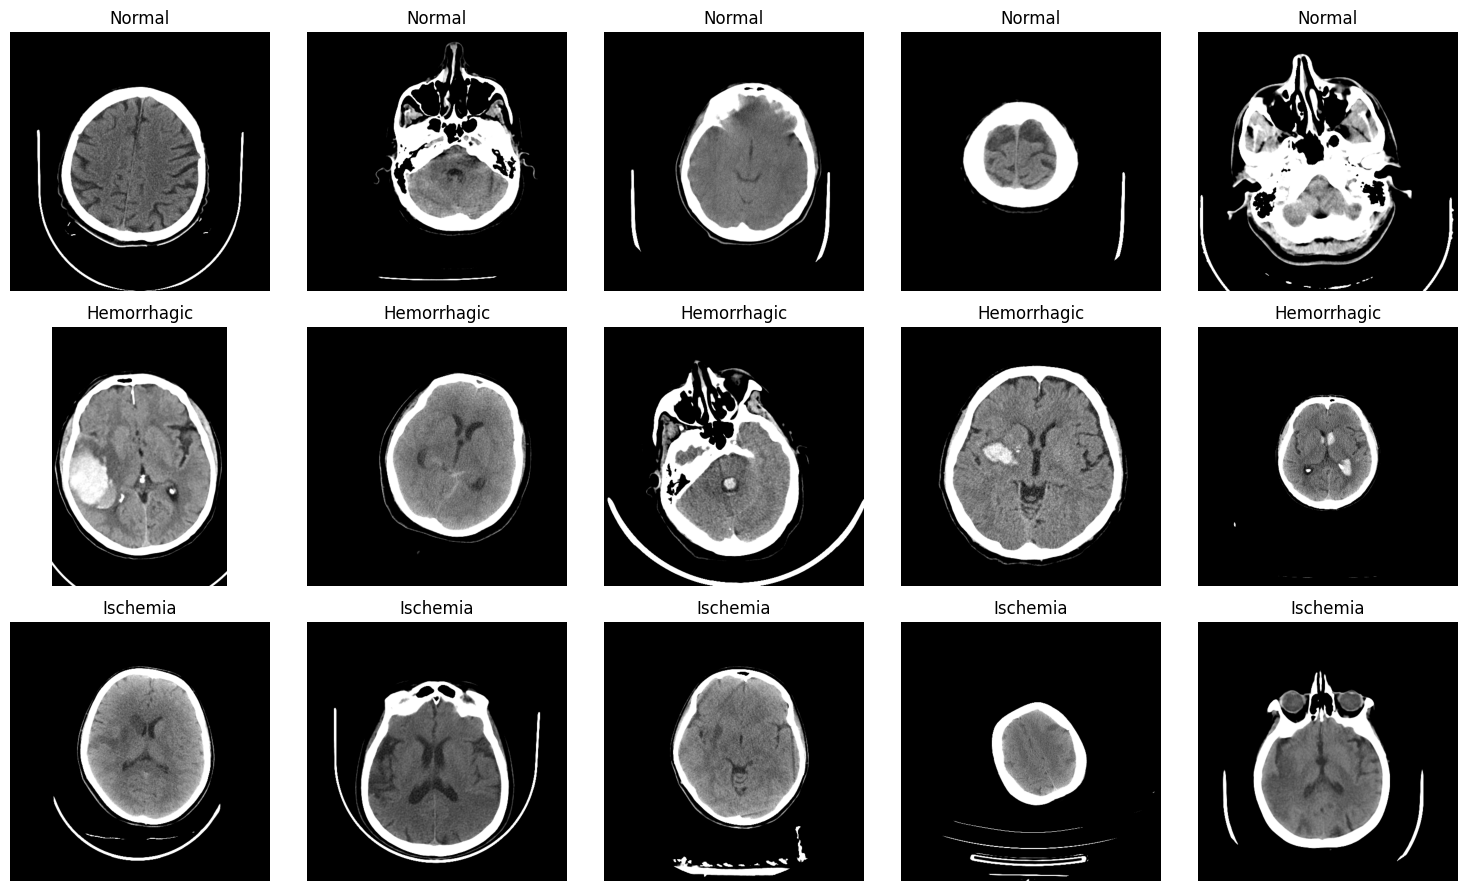

In [7]:
# Visualize some sample images
def show_samples(image_paths, labels, n_samples=5):
    # Get random indices for each class
    indices = {}
    for i in range(3):  # 3 classes
        class_indices = [idx for idx, label in enumerate(labels) if label == i]
        if len(class_indices) >= n_samples:
            indices[i] = np.random.choice(class_indices, n_samples, replace=False)
        else:
            indices[i] = class_indices
    
    # Create figure
    fig, axes = plt.subplots(3, n_samples, figsize=(15, 9))
    
    for i in range(3):  # For each class
        for j in range(min(n_samples, len(indices[i]))):  # For each sample
            idx = indices[i][j]
            img = Image.open(image_paths[idx])
            axes[i, j].imshow(img)
            axes[i, j].set_title(class_names[i])
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample images
show_samples(image_paths, labels)

## MODEL TRAINING 

In [8]:
# Split into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")

Training set: 5320 images
Validation set: 1330 images


In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class BrainCTDatasetInRAM(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.transform = transform
        self.data = []

        print("Loading dataset into RAM...")

        for img_path, label in zip(image_paths, labels):
            # Load image
            image = Image.open(img_path).convert('RGB')

            # Apply transform if provided
            if self.transform:
                image = self.transform(image)
            else:
                image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0

            self.data.append((image, label))  # Store as (image, label) tuple

        print(f"Loaded {len(self.data)} images into RAM.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [10]:
# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
# Replace with the in-memory dataset
train_dataset = BrainCTDatasetInRAM(train_paths, train_labels, transform=transform_train)
val_dataset = BrainCTDatasetInRAM(val_paths, val_labels, transform=transform_val)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,         # In RAM, no need for extra workers (faster on CPU sometimes)
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

Loading dataset into RAM...
Loaded 5320 images into RAM.
Loading dataset into RAM...
Loaded 1330 images into RAM.


In [12]:
# --------------------------------------------------
# 🔄 Model Setup
# --------------------------------------------------

# Use a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer for our 3-class problem
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 classes: Normal, Bleeding, Ischemia

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Set up training parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

c:\FYP\CT Code\MRI\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\FYP\CT Code\MRI\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


In [13]:
# --------------------------------------------------
# 🏋️‍♀️ Training and Validation Functions
# --------------------------------------------------

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(dataloader, desc="Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [14]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Validating"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store predictions and targets for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_targets

In [15]:
# --------------------------------------------------
# 🏃‍♂️ Training Loop
# --------------------------------------------------

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Set training parameters
num_epochs = 20
best_val_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

# Start the training
print("Starting model training...")

Using device: cuda
Starting model training...



Epoch 1/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 240.45it/s]


Train Loss: 0.5821, Train Acc: 0.7795
Val Loss: 0.9662, Val Acc: 0.5797
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.47      0.63       885
 Hemorrhagic       0.78      0.72      0.75       219
    Ischemia       0.28      0.88      0.43       226

    accuracy                           0.58      1330
   macro avg       0.68      0.69      0.60      1330
weighted avg       0.82      0.58      0.62      1330



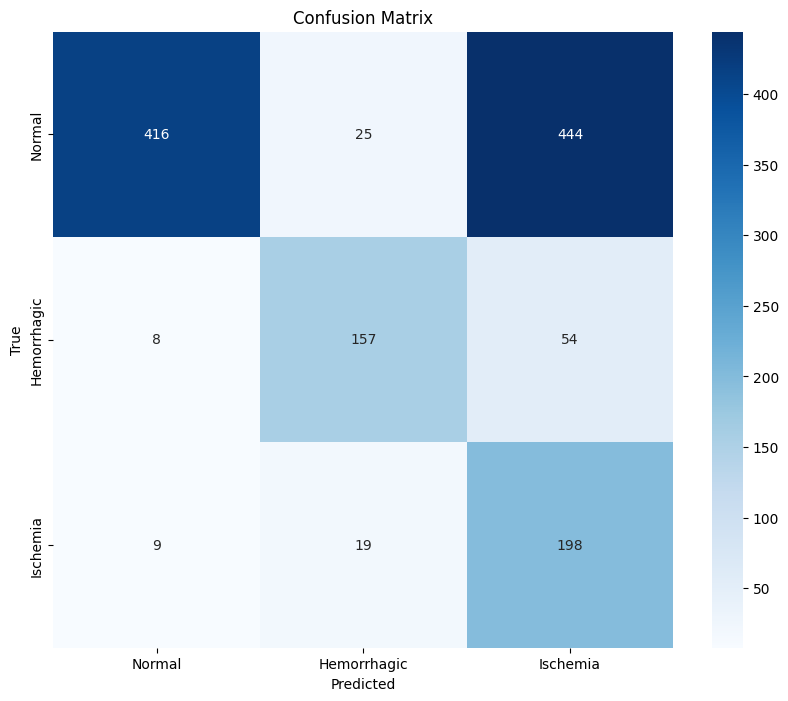


Epoch 2/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 248.97it/s]


Train Loss: 0.4322, Train Acc: 0.8438
Val Loss: 0.3525, Val Acc: 0.8571
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.89      0.91       885
 Hemorrhagic       0.93      0.82      0.87       219
    Ischemia       0.61      0.75      0.67       226

    accuracy                           0.86      1330
   macro avg       0.82      0.82      0.82      1330
weighted avg       0.87      0.86      0.86      1330



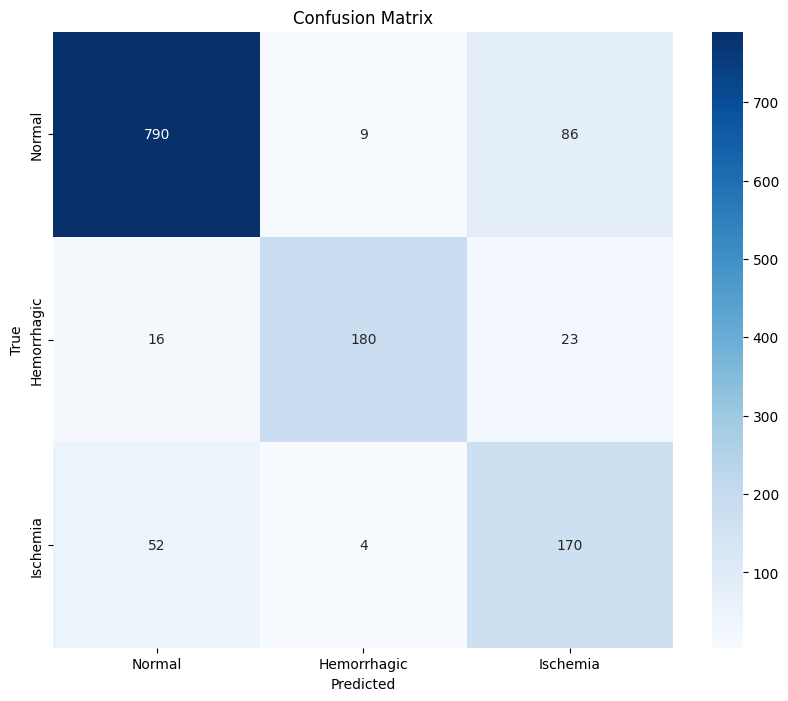


Epoch 3/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 246.61it/s]


Train Loss: 0.3369, Train Acc: 0.8735
Val Loss: 0.5445, Val Acc: 0.7729

Epoch 4/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 248.74it/s]


Train Loss: 0.2805, Train Acc: 0.8985
Val Loss: 0.7075, Val Acc: 0.8188

Epoch 5/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 249.55it/s]


Train Loss: 0.2454, Train Acc: 0.9096
Val Loss: 0.3732, Val Acc: 0.8511

Epoch 6/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 241.81it/s]


Train Loss: 0.1965, Train Acc: 0.9305
Val Loss: 0.3017, Val Acc: 0.8865
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.89      0.92       885
 Hemorrhagic       0.96      0.89      0.92       219
    Ischemia       0.65      0.88      0.75       226

    accuracy                           0.89      1330
   macro avg       0.85      0.88      0.86      1330
weighted avg       0.90      0.89      0.89      1330



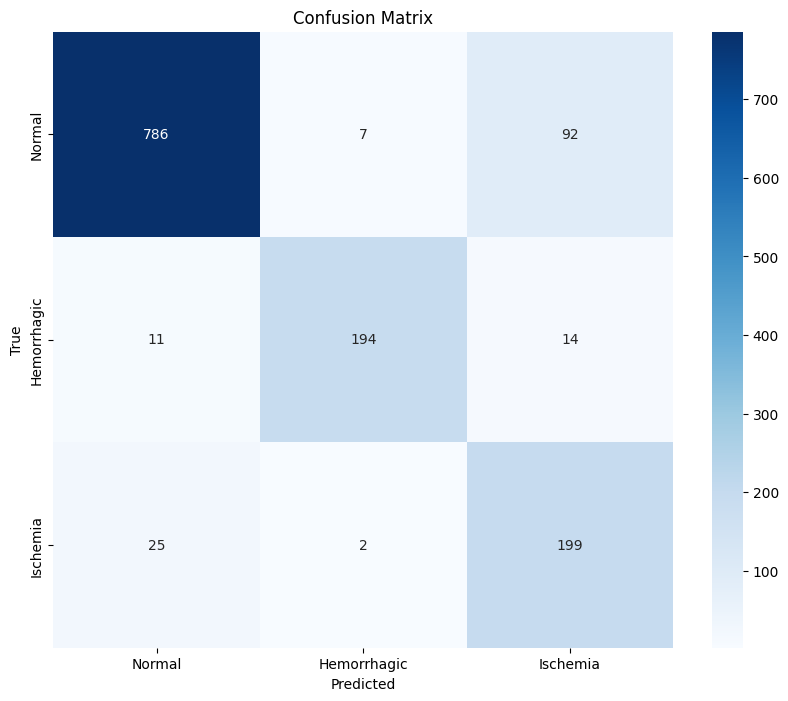


Epoch 7/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 230.74it/s]


Train Loss: 0.1537, Train Acc: 0.9472
Val Loss: 0.3154, Val Acc: 0.8805

Epoch 8/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 230.72it/s]


Train Loss: 0.1267, Train Acc: 0.9551
Val Loss: 0.2983, Val Acc: 0.8970
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.93      0.93       885
 Hemorrhagic       0.92      0.90      0.91       219
    Ischemia       0.73      0.77      0.75       226

    accuracy                           0.90      1330
   macro avg       0.86      0.87      0.86      1330
weighted avg       0.90      0.90      0.90      1330



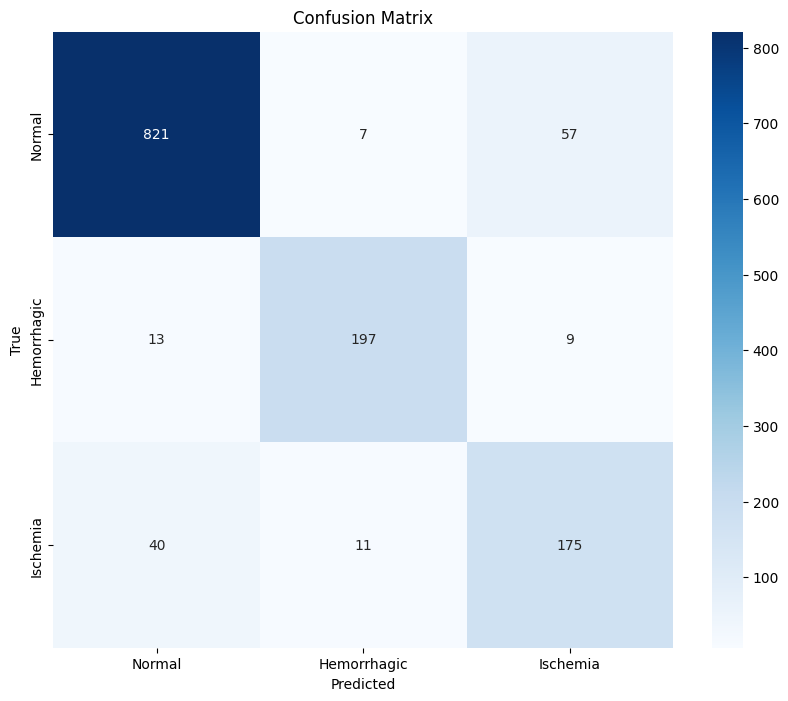


Epoch 9/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 242.40it/s]


Train Loss: 0.1076, Train Acc: 0.9622
Val Loss: 0.4599, Val Acc: 0.8586

Epoch 10/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 242.21it/s]


Train Loss: 0.0991, Train Acc: 0.9656
Val Loss: 0.6833, Val Acc: 0.8782

Epoch 11/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 242.19it/s]


Train Loss: 0.0732, Train Acc: 0.9754
Val Loss: 0.4297, Val Acc: 0.9053
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.90      0.98      0.94       885
 Hemorrhagic       0.94      0.84      0.89       219
    Ischemia       0.87      0.66      0.75       226

    accuracy                           0.91      1330
   macro avg       0.90      0.83      0.86      1330
weighted avg       0.90      0.91      0.90      1330



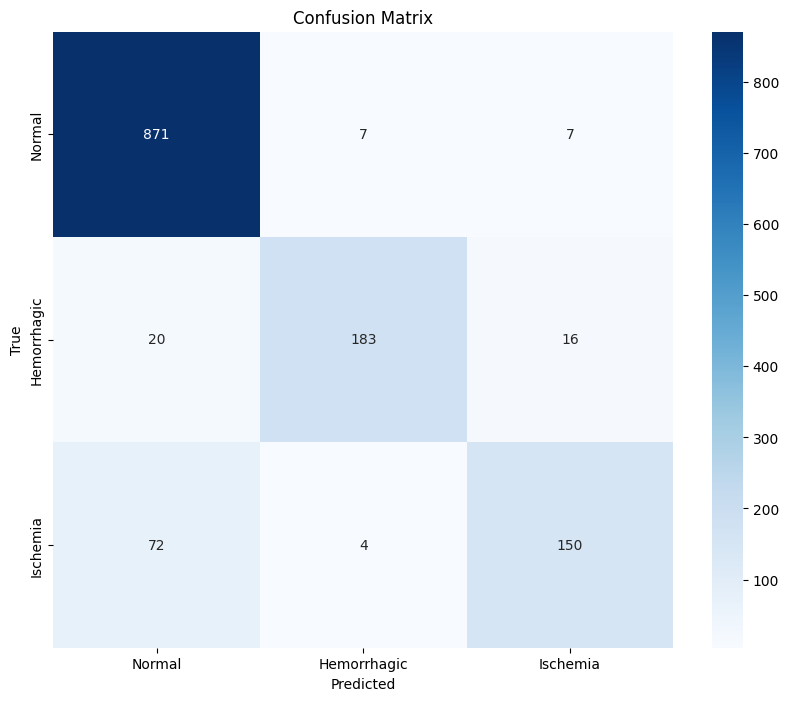


Epoch 12/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 235.98it/s]


Train Loss: 0.0644, Train Acc: 0.9791
Val Loss: 0.3196, Val Acc: 0.9128
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.94      0.94       885
 Hemorrhagic       0.87      0.94      0.91       219
    Ischemia       0.82      0.77      0.79       226

    accuracy                           0.91      1330
   macro avg       0.88      0.88      0.88      1330
weighted avg       0.91      0.91      0.91      1330



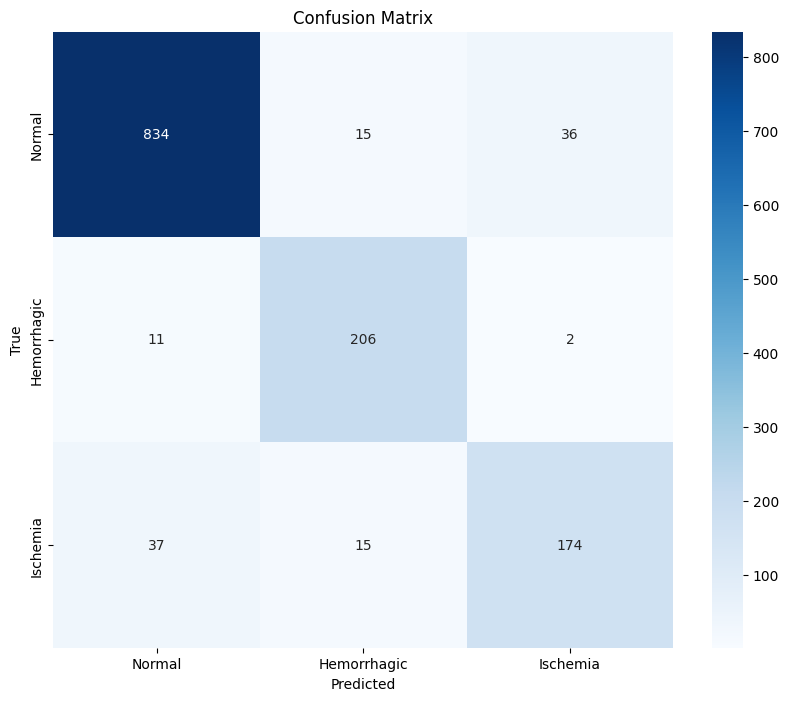


Epoch 13/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 243.45it/s]


Train Loss: 0.0775, Train Acc: 0.9731
Val Loss: 0.3960, Val Acc: 0.9053

Epoch 14/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 244.04it/s]


Train Loss: 0.0479, Train Acc: 0.9852
Val Loss: 0.4496, Val Acc: 0.9150
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.91      0.99      0.94       885
 Hemorrhagic       0.95      0.90      0.93       219
    Ischemia       0.92      0.65      0.76       226

    accuracy                           0.92      1330
   macro avg       0.92      0.85      0.88      1330
weighted avg       0.92      0.92      0.91      1330



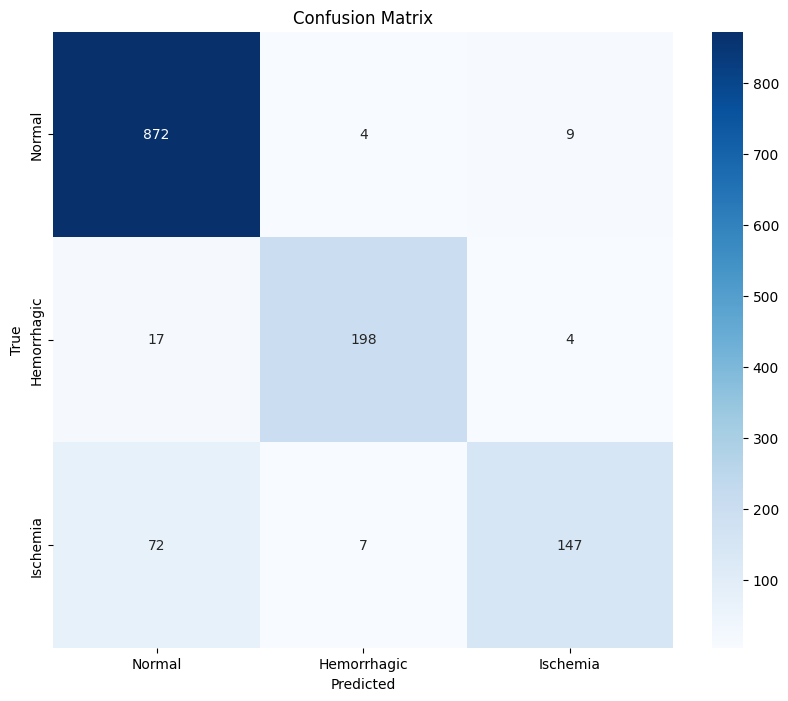


Epoch 15/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 245.36it/s]


Train Loss: 0.0352, Train Acc: 0.9898
Val Loss: 0.5943, Val Acc: 0.8992

Epoch 16/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 243.00it/s]


Train Loss: 0.0611, Train Acc: 0.9803
Val Loss: 0.4750, Val Acc: 0.8970

Epoch 17/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 244.13it/s]


Train Loss: 0.0451, Train Acc: 0.9838
Val Loss: 0.2795, Val Acc: 0.9195
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.94      0.95       885
 Hemorrhagic       0.93      0.89      0.91       219
    Ischemia       0.76      0.86      0.81       226

    accuracy                           0.92      1330
   macro avg       0.89      0.90      0.89      1330
weighted avg       0.92      0.92      0.92      1330



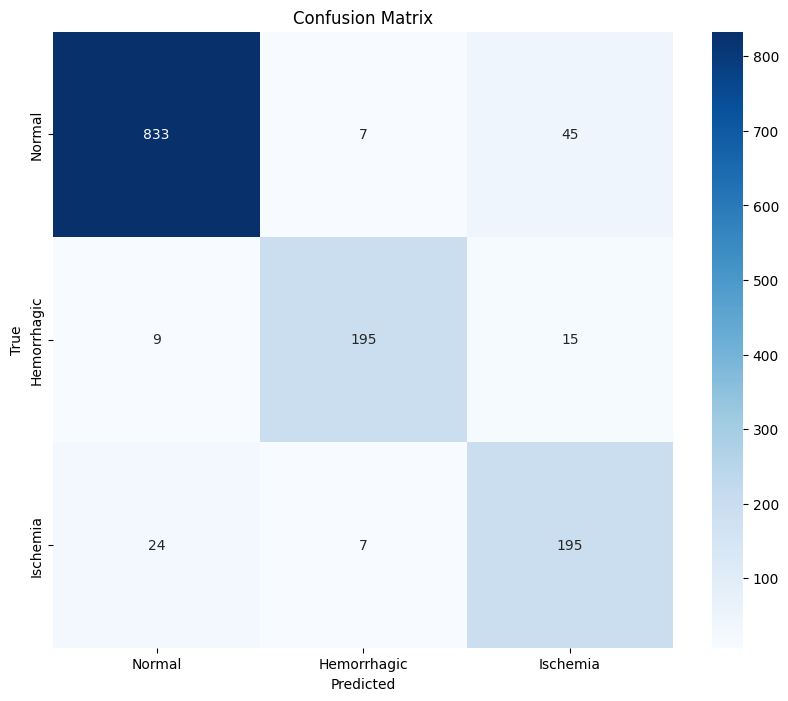


Epoch 18/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 243.29it/s]


Train Loss: 0.0410, Train Acc: 0.9863
Val Loss: 1.6937, Val Acc: 0.6429

Epoch 19/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 245.45it/s]


Train Loss: 0.0506, Train Acc: 0.9823
Val Loss: 0.4618, Val Acc: 0.9143

Epoch 20/20


Validating: 100%|██████████| 84/84 [00:00<00:00, 245.99it/s]


Train Loss: 0.0356, Train Acc: 0.9874
Val Loss: 0.3485, Val Acc: 0.9316
Saved new best model!

Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96       885
 Hemorrhagic       0.97      0.89      0.93       219
    Ischemia       0.86      0.78      0.82       226

    accuracy                           0.93      1330
   macro avg       0.92      0.89      0.90      1330
weighted avg       0.93      0.93      0.93      1330



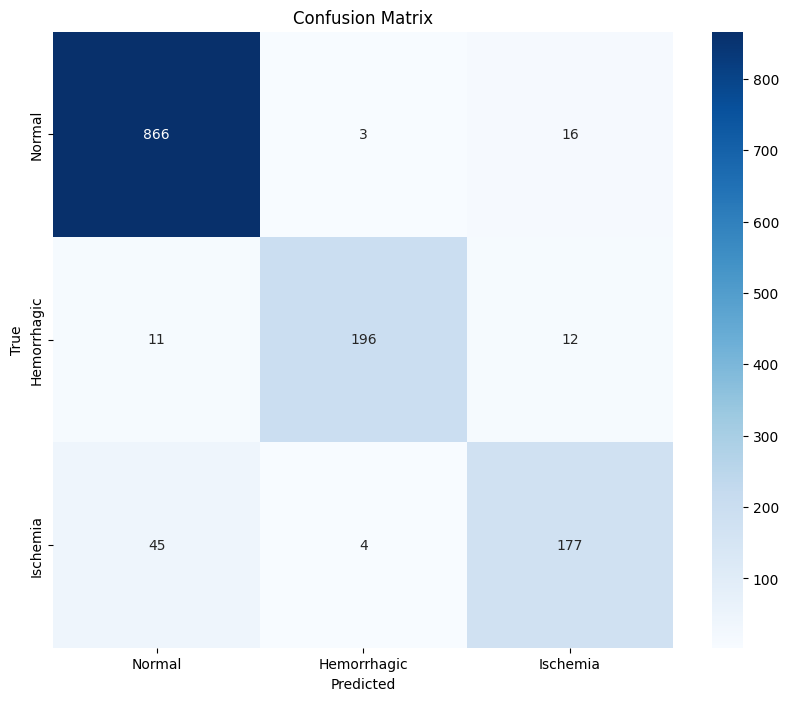

In [16]:
# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc, all_preds, all_targets = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    scheduler.step(val_acc)
    
    # Print statistics
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_brain_ct_model.pth")
        print("Saved new best model!")
        
        # Detailed metrics for best model
        print("\nClassification Report:")
        print(classification_report(all_targets, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_targets, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

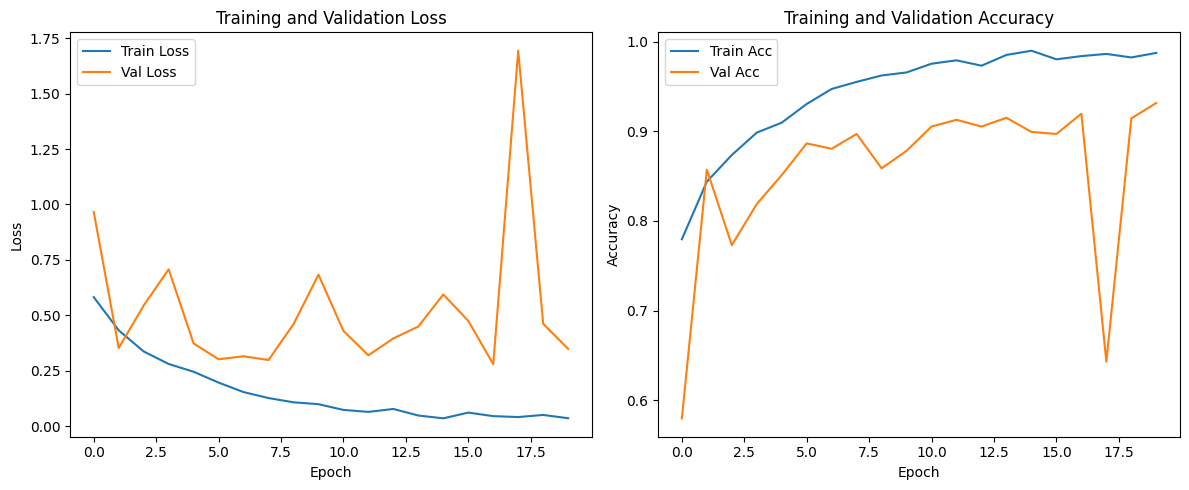

In [17]:
# --------------------------------------------------
# 📊 Training History Visualization
# --------------------------------------------------

# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Validating: 100%|██████████| 84/84 [00:00<00:00, 155.91it/s]



Final Validation Accuracy: 0.9316

Final Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.98      0.96       885
 Hemorrhagic       0.97      0.89      0.93       219
    Ischemia       0.86      0.78      0.82       226

    accuracy                           0.93      1330
   macro avg       0.92      0.89      0.90      1330
weighted avg       0.93      0.93      0.93      1330



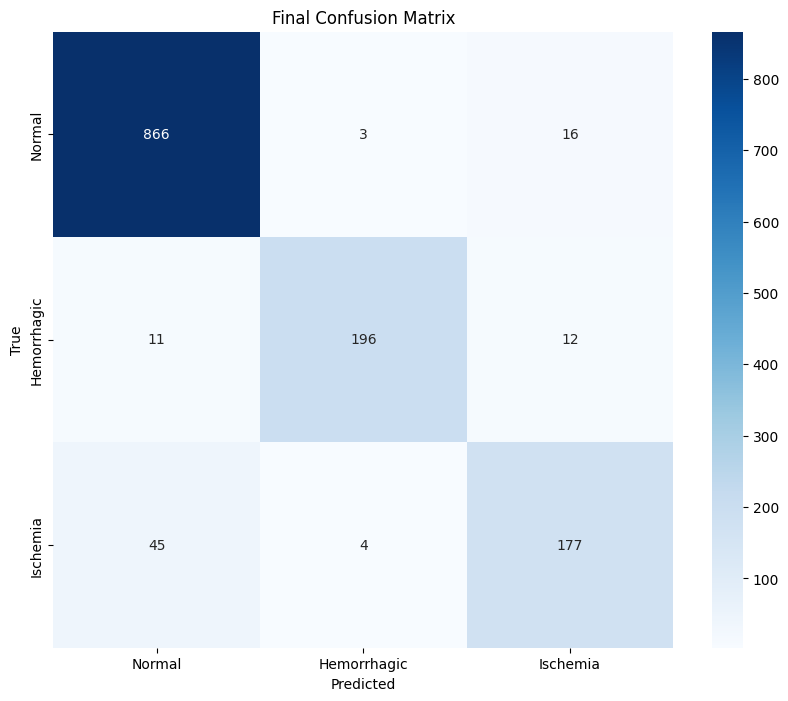

In [18]:
# --------------------------------------------------
# 🔍 Load Best Model and Final Evaluation
# --------------------------------------------------

# Load the best model
model.load_state_dict(torch.load("best_brain_ct_model.pth"))

# Final evaluation
_, final_acc, final_preds, final_targets = validate(model, val_loader, criterion, device)
print(f"\nFinal Validation Accuracy: {final_acc:.4f}")

# Print detailed classification report
print("\nFinal Classification Report:")
print(classification_report(final_targets, final_preds, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(final_targets, final_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Final Confusion Matrix')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def evaluate_model_accuracy(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Run the evaluation
evaluate_model_accuracy(model, val_loader)


Validation Accuracy: 93.16%


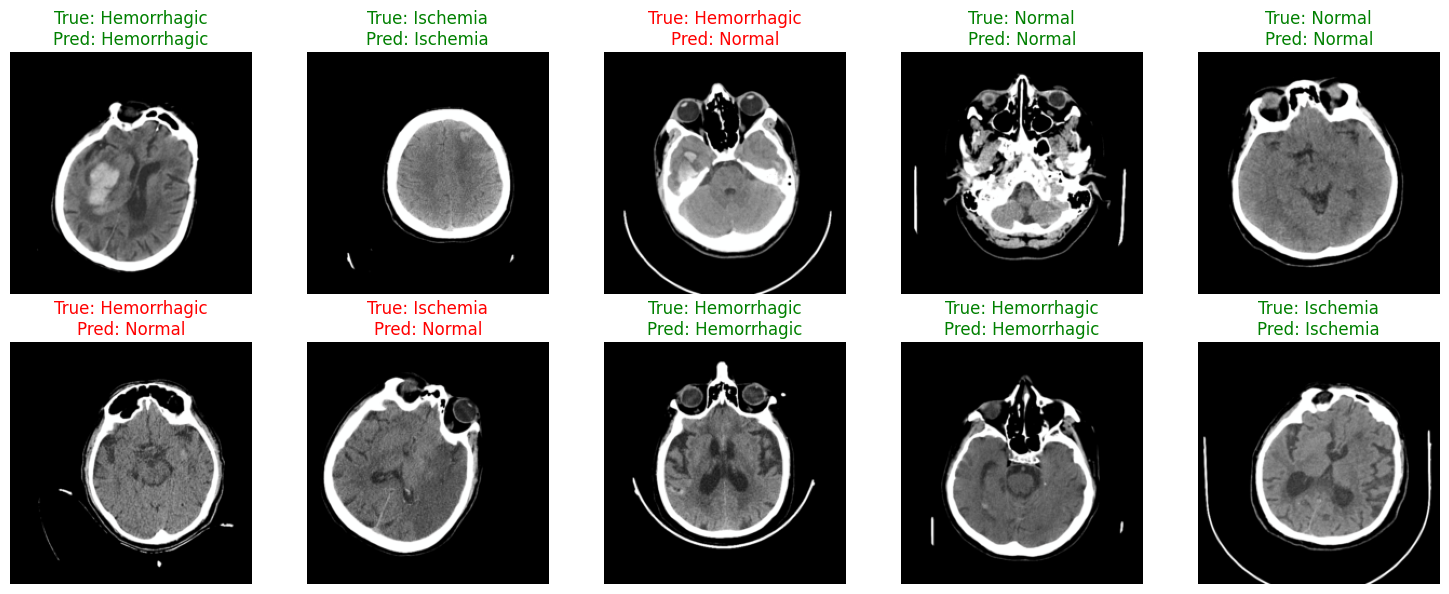

In [19]:
# --------------------------------------------------
# 🖼️ Visualize Model Predictions
# --------------------------------------------------

def visualize_predictions(model, dataloader, class_names, num_samples=10):
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            
            # Store batch data
            all_images.extend(inputs.cpu())
            all_labels.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            
            if len(all_images) >= num_samples:
                break
    
    # Limit to requested number of samples
    all_images = all_images[:num_samples]
    all_labels = all_labels[:num_samples]
    all_preds = all_preds[:num_samples]
    
    # Visualize
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, (img, label, pred) in enumerate(zip(all_images, all_labels, all_preds)):
        if i >= len(axes):
            break
            
        # Denormalize image
        img = img.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Display
        axes[i].imshow(img)
        color = 'green' if label == pred else 'red'
        axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}", color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions(model, val_loader, class_names)


Evaluating model on external test set...
Found 200 images in external test set


Predicting: 100%|██████████| 13/13 [00:00<00:00, 18.45it/s]
c:\FYP\CT Code\MRI\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\FYP\CT Code\MRI\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\FYP\CT Code\MRI\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


CSV file content preview:
image_id,Stroke
10189,0
10200,0
10231,0
10267,0
10300,0
10301,0
10319,0
10360,0
10467,0
10493,0
10494,0
10641,0
10693,0
10833,0
10910,0
10911,0
10917,0
10923,0
11023,0
11072,0
11308,0
11319,0
11465,0
...
CSV columns: ['image_id', 'Stroke']
First few rows:
   image_id  Stroke
0     10189       0
1     10200       0
2     10231       0
3     10267       0
4     10300       0
Matched 200 images with labels

External Test Accuracy: 0.7750

External Test Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.92      0.93       130
 Hemorrhagic       0.95      0.51      0.67        70
    Ischemic       0.00      0.00      0.00         0

    accuracy                           0.78       200
   macro avg       0.63      0.48      0.53       200
weighted avg       0.94      0.78      0.84       200



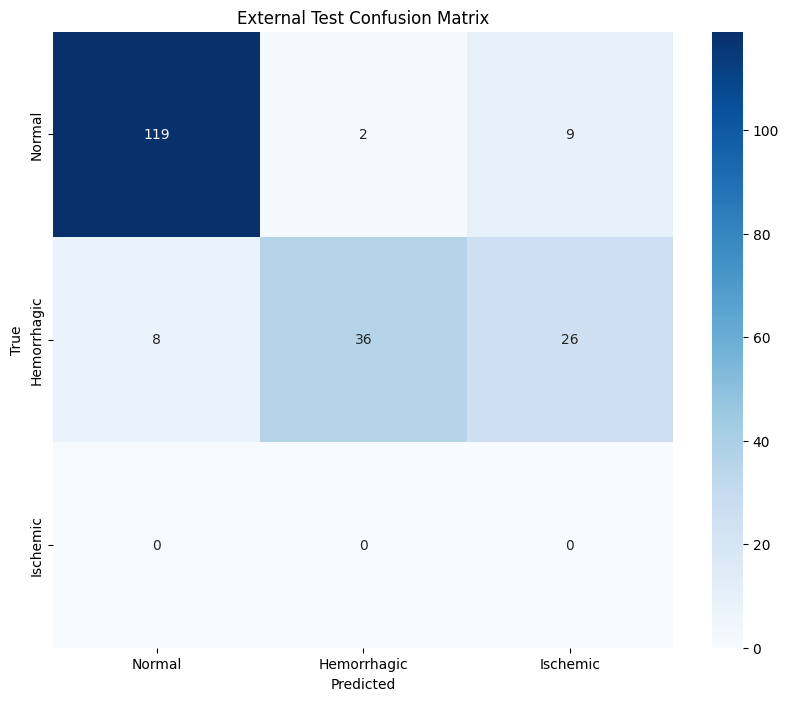

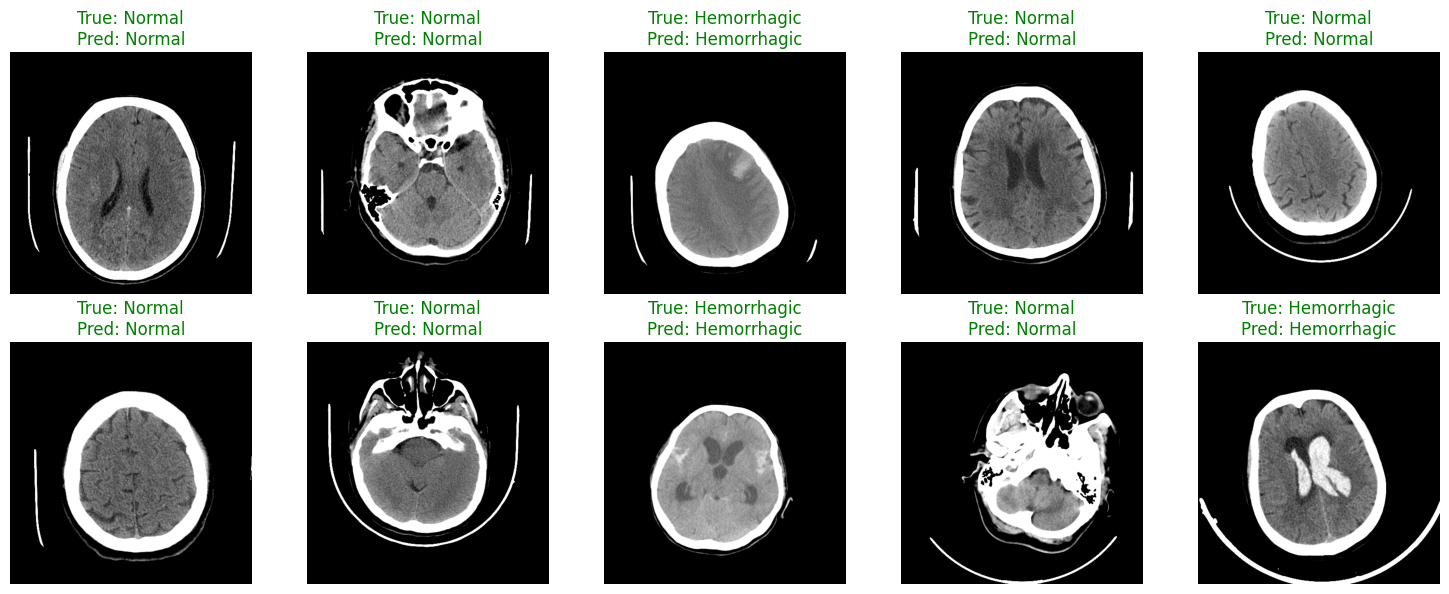


Incorrect Predictions:
File: 11023.png, True: Normal, Pred: Ischemic
File: 12933.png, True: Normal, Pred: Ischemic
File: 13477.png, True: Normal, Pred: Ischemic
File: 13497.png, True: Normal, Pred: Ischemic
File: 13708.png, True: Normal, Pred: Hemorrhagic
File: 14522.png, True: Normal, Pred: Ischemic
File: 15028.png, True: Normal, Pred: Ischemic
File: 15550.png, True: Normal, Pred: Ischemic
File: 16039.png, True: Normal, Pred: Ischemic
File: 16493.png, True: Normal, Pred: Hemorrhagic


In [21]:
# Testing on External Test Set
external_test_path = os.path.join(dataset_path, "External_Test", "PNG")
if os.path.exists(external_test_path):
    print("\nEvaluating model on external test set...")
    
    # Load all test images
    test_images = glob.glob(os.path.join(external_test_path, "*.png"))
    print(f"Found {len(test_images)} images in external test set")
    
    # Create a dataset without labels (we'll add them later)
    class ImageOnlyDataset(Dataset):
        def __init__(self, image_paths, transform=None):
            self.image_paths = image_paths
            self.transform = transform
            
        def __len__(self):
            return len(self.image_paths)
        
        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            else:
                image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0
                
            return image, os.path.basename(img_path)  # Return image and filename
    
    # Create dataset and dataloader
    test_dataset = ImageOnlyDataset(test_images, transform=transform_val)

    batch_size = 16  # You can choose any reasonable batch size

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Get predictions for all images
    model.eval()
    all_filenames = []
    all_predictions = []
    all_raw_outputs = []
    
    with torch.no_grad():
        for images, filenames in tqdm(test_loader, desc="Predicting"):
            images = images.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            
            # Store results
            all_filenames.extend(filenames)
            all_predictions.extend(preds.cpu().numpy())
            all_raw_outputs.extend(outputs.cpu().numpy())
    
    # Create a dictionary of predictions
    prediction_dict = {filename: pred for filename, pred in zip(all_filenames, all_predictions)}
    
    # Try to load and parse the CSV
    labels_path = os.path.join(dataset_path, "External_Test", "labels.csv")
    if os.path.exists(labels_path):
        # Try to read the CSV file directly
        with open(labels_path, 'r') as f:
            csv_content = f.read()
            print("CSV file content preview:")
            print(csv_content[:200] + "..." if len(csv_content) > 200 else csv_content)
        
        # Load labels
        labels_df = pd.read_csv(labels_path)
        print("CSV columns:", labels_df.columns.tolist())
        print("First few rows:")
        print(labels_df.head())
        
        # Extract image IDs and labels
        # Assuming format is like "10189,0" in a single column
        if ',' in str(labels_df.iloc[0, 0]):
            # Split by comma
            labels_df['image_id'] = labels_df.iloc[:, 0].str.split(',').str[0]
            labels_df['label'] = labels_df.iloc[:, 0].str.split(',').str[1].astype(float).astype(int)
        else:
            # Assume first column is ID, second is label
            labels_df['image_id'] = labels_df.iloc[:, 0]
            labels_df['label'] = labels_df.iloc[:, 1]
        
        # Match predictions with ground truth
        matched_files = []
        true_labels = []
        pred_labels = []
        
        for idx, row in labels_df.iterrows():
            image_id = str(row['image_id'])
            true_label = int(row['label'])
            
            # Find corresponding image file
            matched_file = None
            
            # Try exact match first
            exact_matches = [f for f in all_filenames if image_id in f]
            if exact_matches:
                matched_file = exact_matches[0]
            
            if matched_file:
                matched_files.append(matched_file)
                true_labels.append(true_label)
                pred_labels.append(prediction_dict[matched_file])
        
        print(f"Matched {len(matched_files)} images with labels")
        
        if len(matched_files) > 0:
            # Class names for multi-class evaluation
            class_names = ['Normal', 'Hemorrhagic', 'Ischemic']

            # Calculate metrics for multi-class
            accuracy = accuracy_score(true_labels, pred_labels)

            print(f"\nExternal Test Accuracy: {accuracy:.4f}")
            print("\nExternal Test Classification Report:")
            print(classification_report(true_labels, pred_labels, target_names=class_names))

            # Plot confusion matrix for multi-class
            cm = confusion_matrix(true_labels, pred_labels)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('External Test Confusion Matrix')
            plt.show()
            
            # Visualize some examples
            vis_indices = np.random.choice(len(matched_files), min(10, len(matched_files)), replace=False)
            
            fig, axes = plt.subplots(2, 5, figsize=(15, 6))
            axes = axes.flatten()
            
            for i, idx in enumerate(vis_indices):
                if i >= len(axes):
                    break
                
                # Load and display image
                img_path = os.path.join(external_test_path, matched_files[idx])
                img = Image.open(img_path).convert('RGB')
                
                # Display
                axes[i].imshow(img)
                true_label = true_labels[idx]
                pred_label = pred_labels[idx]
                color = 'green' if true_label == pred_label else 'red'
                axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color=color)
                axes[i].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # List incorrect predictions
            incorrect_indices = [i for i, (t, p) in enumerate(zip(true_labels, pred_labels)) if t != p]
            if incorrect_indices:
                print("\nIncorrect Predictions:")
                for i in incorrect_indices[:min(10, len(incorrect_indices))]:
                 print(f"File: {matched_files[i]}, True: {class_names[true_labels[i]]}, Pred: {class_names[pred_labels[i]]}")
            else:
                print("\nAll predictions are correct!")
        else:
            print("No matches found between images and labels")
    else:
        print("External test set found but no labels.csv file")
else:
    print("External test set not found")